In [1]:
import xarray as xr
import pickle 
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#from eofs.xarray import Eof
from eofs.multivariate.iris import MultivariateEof
import iris
import datetime
from eofs.xarray import Eof


Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


#### Preprocessing  - Reanalysedaten 

In [4]:
# Eingabe der gewählten Reanalyse-daten
rea_selection = "era"

# TODO maybe choose variable combination for validation later in this dict
rea_info = {
    "era": {'path':'C:/Users/Aspire_NB/Desktop/era5_data/small_era5_daily.nc',
            'vars':['r', 'q']},
}


try:
    ds_rea = xr.open_mfdataset(rea_info[rea_selection]['path'], decode_cf=True)
except KeyError:
    print("Choose a valid reanalysis from these options: {}".format(', '.join(rea_info.keys())))
    raise
except:
    print("Unexpected error")
    raise

In [5]:
# Aufbereiten der ERA-Reanalysedaten   -------------------------------------------------------------------------------------
if rea_selection == 'era':
    ds_rea = xr.open_mfdataset("C:/Users/Aspire_NB/Desktop/era5_data/era5_daily.nc", decode_cf=True).chunk({'time':-1})
    ds_rea = ds_rea.rename({'latitude': 'lat', 'longitude': 'lon'})
pass

#### Berechnen der Anomalien

In [6]:
#Function, die die Anomalien nach oben erklärtem Schema berechnet:
def calc_normalized_anomalies(ds_prep, window_size=21):
    """
    This method prepares the input Dataset. It calculates the normalized anomalies with means
    and std calculated with a centered window of size window_size
    """
    
    #Resample mit dem Mittel über die Daten, falls die zeitliche Auflösung höher ist als die tägliche
    if pd.infer_freq(ds_prep.time.data) not in 'D':
        ds_prep = ds_prep.resample(time='1D').mean()
        ds_prep = ds_prep.chunk({'time':-1})

    #Berechnen der Klimatology und der Standardabweichung    
    ds_prep_roll = ds_prep.rolling(time=window_size, center=True).construct('window_dim') # mit einem rollenden Zeitfenster (21Tage)

    #Mittel bilden (die ersten und letzten Fenster werden berücksichtigt, auch wenn Zeitschritte fehlen)
    ds_prep_clim = ds_prep_roll.groupby('time.dayofyear').mean(dim=['window_dim','time'])

    #Berechnung der Standardabweichung für das rollende Fenster über den Target Day (TD) inkl. Pool (+-10Tage)
    ds_prep_std = ds_prep_roll.groupby('time.dayofyear').std(dim=xr.ALL_DIMS) # Calculates the std for dayofyear of TD + pool, shape(365,)

    #Berechnung der täglichen normierten Anomalien (mit Mittel und Standardabweichung des TD+pool)
    ds_prep = ds_prep.groupby('time.dayofyear') - ds_prep_clim
    ds_rea = ds_prep.groupby('time.dayofyear') / ds_prep_std

    #nach groupby: rechunken
    ds_rea = ds_rea.chunk({'time': -1})

    return ds_rea

In [7]:
# Normierte Anomalien berechnen und die neue Dimension (rolled dimension) zusammenbauen
ds_rea = calc_normalized_anomalies(ds_rea)
ds_rea_roll = ds_rea.rolling(time=21, center=True).construct('window_dim')

C:\Users\Aspire_NB\Anaconda3\envs\Klimaenvironment\lib\site-packages\xarray\core\indexing.py:1195: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


In [8]:
#Ausgabe der Anomalien
ds_rea

<xarray.Dataset>
Dimensions:    (lat: 141, lon: 141, time: 14610)
Coordinates:
  * lon        (lon) float32 -10.0 -9.75 -9.5 -9.25 ... 24.25 24.5 24.75 25.0
  * lat        (lat) float32 67.5 67.25 67.0 66.75 ... 33.25 33.0 32.75 32.5
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    dayofyear  (time) int64 dask.array<shape=(14610,), chunksize=(14610,)>
Data variables:
    r          (time, lat, lon) float32 dask.array<shape=(14610, 141, 141), chunksize=(14610, 141, 141)>
    q          (time, lat, lon) float32 dask.array<shape=(14610, 141, 141), chunksize=(14610, 141, 141)>
    msl        (time, lat, lon) float32 dask.array<shape=(14610, 141, 141), chunksize=(14610, 141, 141)>

C:\Users\Aspire_NB\Anaconda3\envs\Klimaenvironment\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


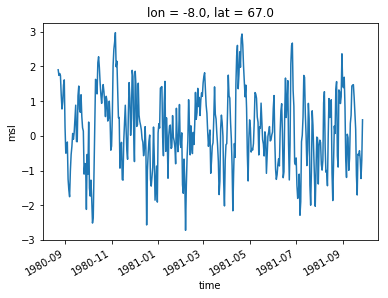

In [9]:
#Plotten der Anomalien für den Parameter: MSL, für bestimmten Zeitausschnitt und Lat/Lon
ds_rea.msl[600:1000,2,8].plot()
plt.savefig('Anomalien.png')

Ausschnitt der berechneten Anomalien 

In [10]:
#Abspeichern der Anomalien als nc-Datei
anomalien = './all_anom.nc'
#print ('saving to ', anomalien)
ds_rea.to_netcdf(path=anomalien)
ds_rea.close()

In [2]:
#Einlesen der zuvor berechneten Anomalien als nc-Datei
anomalien = xr.open_dataset('./all_anom.nc', chunks={'time': 5000, 'lat':141, 'lon': 141})

In [3]:
#Erstellen eines Dataframes für das Ergebnis des Analogons
analogon = pd.DataFrame(columns=['init_day', 'corresponding_day'])

#Listen für 0.9 - Varianz
N_list=np.array([]) 
var_list=np.array([])

### Norm berechnen
Der weitere Schritt führt zur Berechnung der Norm im EOF-Raum, diese wird für jeden Target Day (TD) durchgeführt, dh. für jeden Tag wird die Norm zwischen den entsprechenden Pseudo-PCs und den PCs ermittelt. Werden nun mit der erklärten Varianz zB. 10 EOFs berechnet, so ergeben sich für einen bestimmten TD 10 Pseudo-PCs. Diese werden von den PCs abgezogen, quadriert und über alle Terme (in diesem Fall sind es 10) wird die Summe gebildet, was der Normberechnung entspricht. Es resultiert also für jeden Zeitpunkt, der in den PCs enthalten (DOY +- d x Anzahl Jahre) ist, eine Norm.

$Norm=calculate\_Norm(Pseudo\_PCs, PCs)$


### Analogmethode

Das Ziel der Analogmethode ist das Finden des ähnlichsten beobachtetetn großskaligen Musters. Dabei wird die geringste Abweichung der jeweiligen Parameter gesucht. Dies erfolgt über die Suche nach dem Minimum über die berechneten Normen (argmin(norm)). Der zugehörige Tag der PCs an dem die Norm minimal ist, ist jener Tag, an welchem die lokalen Daten (Spartacus) für das downgescalte Feld am TD herangezogen werden.

$Analoga =argmin(Norm))$

Die Analoga werden dabei nicht weggeworfen, sondern als Liste abgespeichert.


In [4]:
#Analogmethode

for doy in range(1,367):   # Schleife geht über alle 366 DOY
    print('target day: ', doy) # = Target Day
    
    # Bestimmen der benötigten doy im Zeitfenster
    days = np.arange(doy-10,doy+11)
    days[days<=0] = days[days<=0]+366
    days[days>366] = days[days>366]-366
    
    # Ausschneiden der 21 Tage (in allen Jahren), Größe: 21 Tage x 40 Jahre x 141x141
    anomalien_i_q = anomalien.q.where(anomalien.q.dayofyear.isin(days),drop=True).to_iris()
    anomalien_i_r = anomalien.r.where(anomalien.r.dayofyear.isin(days),drop=True).to_iris()
    anomalien_i_msl = anomalien.msl.where(anomalien.msl.dayofyear.isin(days),drop=True).to_iris()
    #print (anomalies_i_q)
    
    ###### Multivariate EOF-Berechnung#######
    # solver-Objekt erzeugen
    solver = MultivariateEof([anomalien_i_q,anomalien_i_r,anomalien_i_msl])
    
    #Erzeugen der PCs bis 90% erklärte Varianz:
    N = 1
    var = 0
    while var < .9:
        var = np.sum(solver.varianceFraction(neigs=N).data)
        N = N+1
    N_list = np.append(N_list,N)
    var_list = np.append(var_list,var)
    pcs = solver.pcs(npcs=N)
    pcs_x = xr.DataArray.from_iris(pcs) # Umwandeln der PCs in xarray
    del pcs    
    
    for year in np.arange(1979,2019): # Loop über verfügbaren Jahre
        # Ausschneiden der einen benötigten Analyse (= ein Tag), Größe: 141x141
        single_q = anomalien.q.sel(time=((anomalien.time.dt.year == year)&(anomalien.dayofyear == doy))).to_iris()
        single_r = anomalien.r.sel(time=((anomalien.time.dt.year == year)&(anomalien.dayofyear == doy))).to_iris()
        single_msl = anomalien.msl.sel(time=((anomalien.time.dt.year == year)&(anomalien.dayofyear == doy))).to_iris()
        
        if single_q.coord('time').points.size > 0:  # nur wenn der doy in dem Jahr existiert (doy 366 nur in Schaltjahren)
            
            # Berechnen der Pseudo-PCs für den einen Tag
            pseudo_pcs = solver.projectField([single_q, single_r, single_msl], neofs=N)
            #print (pseudo_pcs)
        
            # Minimieren der Norm (=Suchen des analogen Tags = 'corresp_day')
            corresp_idx=np.argmin(np.sum(np.sqrt((pcs_x.sel(time=~(pcs_x.time.dt.year == year)).data - pseudo_pcs.data)**2),axis=1)) # Index im pcs
        
            init_day = anomalien.sel(time=((anomalien.time.dt.year == year)&(anomalien.dayofyear == doy))).time[0].data # 'aktueller Tag'
            corresponding_day = pcs_x.sel(time=~(pcs_x.time.dt.year == year)).isel(time=corresp_idx).time.data
            
            analogon = analogon.append(pd.DataFrame([[pd.to_datetime(init_day),pd.to_datetime(corresponding_day)]],columns=['init_day', 'corresponding_day']))

target day:  1
target day:  2
target day:  3
target day:  4
target day:  5
target day:  6
target day:  7
target day:  8
target day:  9
target day:  10
target day:  11
target day:  12
target day:  13
target day:  14
target day:  15
target day:  16
target day:  17
target day:  18
target day:  19
target day:  20
target day:  21
target day:  22
target day:  23
target day:  24
target day:  25
target day:  26
target day:  27
target day:  28
target day:  29
target day:  30
target day:  31
target day:  32
target day:  33
target day:  34
target day:  35
target day:  36
target day:  37
target day:  38
target day:  39
target day:  40
target day:  41
target day:  42
target day:  43
target day:  44
target day:  45
target day:  46
target day:  47
target day:  48
target day:  49
target day:  50
target day:  51
target day:  52
target day:  53
target day:  54
target day:  55
target day:  56
target day:  57
target day:  58
target day:  59
target day:  60
target day:  61
target day:  62
target day:  63
t

In [5]:
analogon = analogon.sort_values('init_day') #Reihenfolge sortieren

#Abspeichern der Ergebnis-Listen
#pickle.dump(analogon, open( "analogon_list.pickle", "wb" ) )
pickle.dump(N_list, open( "N_list.pickle", "wb" ) )
pickle.dump(var_list, open( "var_list.p", "wb" ) )
print(analogon)

     init_day corresponding_day
0  1979-01-01        2003-01-04
0  1979-01-02        1995-01-12
0  1979-01-03        1981-01-05
0  1979-01-04        1986-01-07
0  1979-01-05        2010-01-07
0  1979-01-06        1990-01-07
0  1979-01-07        2008-01-08
0  1979-01-08        1988-01-17
0  1979-01-09        2015-01-16
0  1979-01-10        1994-01-05
0  1979-01-11        1994-01-04
0  1979-01-12        2013-01-15
0  1979-01-13        1981-01-05
0  1979-01-14        1986-01-07
0  1979-01-15        2000-01-19
0  1979-01-16        2012-01-10
0  1979-01-17        2011-01-23
0  1979-01-18        1996-01-28
0  1979-01-19        1996-01-29
0  1979-01-20        2010-01-13
0  1979-01-21        1996-01-29
0  1979-01-22        1996-01-29
0  1979-01-23        2001-01-29
0  1979-01-24        2003-01-28
0  1979-01-25        2001-01-27
0  1979-01-26        1998-02-02
0  1979-01-27        2009-02-05
0  1979-01-28        1988-02-07
0  1979-01-29        2013-01-22
0  1979-01-30        1984-01-25
..      

### Validierung

Um eine gewisse Vorhersagegenauigkeit zu garantieren muss überprüft werden, wie gut die gewählten Transferfunktionen sind. Dies geschieht mit Hilfe der Validierung.

Für die anschließende Validierung werden der „Initial day“ und der „Corresponding day“ miteinander verglichen. Damit soll veranschaulicht werden, wie stark die (von der Analogmethode ausgewählten) Tage voneinander abweichen. Als Referenz (Initial Day) werden die Anomalien herangezogen, als Corresponding Day (Analoga) jene der PCs. Um starke bzw. weniger starke Abweichungen übersichtlich darzustellen, wird von diesen beiden Parametern der RMSE (root mean square error) berechnet. Dieser wird für jeden Tag ermittelt und ist ein Maß für die Genauigkeit. Die Formel dafür lautet: 

$RMSE=\sqrt{\frac{1}{N} \sum day_{corresp}-day_{init}}$

Der RMSE wichtet große Fehler sehr stark, hierbei ist schnell zu erkennen, an welchen Tagen die Differenz besonders groß bzw. besonders klein ist. Ein RMSE von 0 bedeutet dass der Unterschied gering ist. In dieser Arbeit wird anschließend ein Fall mit größtem und ein Fall mit kleinstem RMSE gezeigt.

In [6]:
analogon=analogon.drop_duplicates()
analogon['daynum']=np.arange(0,len(analogon))
analogon.tail()

,init_day,corresponding_day,daynum
0,2018-12-27,1988-12-26,14605
0,2018-12-28,1988-12-27,14606
0,2018-12-29,2008-12-21,14607
0,2018-12-30,1991-12-27,14608
0,2018-12-31,2008-12-21,14609


In [14]:
analogon.to_pickle("analogon_list.pickle")
#analogon=pd.read_pickle(analogon_list.pickle)

In [7]:
import iris.quickplot as qplot
import matplotlib.pyplot as plt
from six.moves import (filter,input,map,range,zip)

In [8]:
# Anomalien in Iris-Cube für spätere Schleife umwandeln
anomalien_r= anomalien.r.to_iris()
anomalien_q=anomalien.q.to_iris()
anomalien_msl=anomalien.msl.to_iris()

In [12]:
level=np.arange(-2,2,0.1) #Legende colorbar
rmse_list=[]

In [19]:
rmse_list=[]
for i in analogon['daynum']:
    day_r=i
    j=analogon[analogon['daynum']==i]['corresponding_day'][0] #sucht den aktuellen numerierten analog day
    
    j=pd.to_datetime(j)
    day_c=analogon[analogon['init_day']==j]['daynum']
    #qplot.contourf(anomalien_r[day_c[0]]-anomalien_r[day_r], level, cmap='RdBu_r') #Differenz aus init day und correspond. day
    
    #Berechnen des RMSE
    rmsecube=(anomalien_r[day_c[0]]-anomalien_r[day_r])**2
    rmsecube2=rmsecube.collapsed('longitude',iris.analysis.MEAN)
    rmsecube3=rmsecube2.collapsed('latitude',iris.analysis.MEAN)
    
    rmse=(np.sqrt(rmsecube3.data))
    #plt.title('Init. date:'+str(analogon[analogon['daynum']==i]['init_day'][0]) + '\n Corresponding day:' + str(analogon[analogon['daynum']==i]['corresponding_day'][0]) +'\n RMSE: ' + str(rmse))
    
    rmse_list.append(rmse)
    
    #plt.show()

KeyboardInterrupt: 

In [40]:
#print(len(rmse_list))

In [21]:
pickle.dump(rmse_list, open( "rmse_list.pickle", "wb" ) )

In [39]:
rmse_list[0:15]

[1.0356301,
 0.99095374,
 0.9701398,
 1.1861924,
 1.1282269,
 1.0738947,
 0.9488089,
 0.9356373,
 0.9881601,
 0.9778781,
 0.96325326,
 0.92097646,
 1.0798789,
 1.1180792,
 0.95033437]

In [22]:
#Maximum und Minimum der RMSE-Werte finden
maxi=rmse_list.index(max(rmse_list))
mini=rmse_list.index(min(rmse_list))

In [26]:
max(rmse_list)

1.4150174

In [23]:
#len(analogon['daynum'])

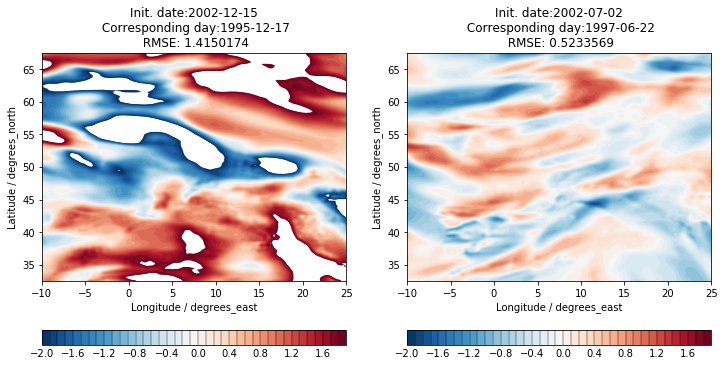

In [42]:
import cartopy.crs as ccrs
ju=1
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())

#Plot der Analogons mit jeweils maximalem und minimalem RMSE
for i in [rmse_list.index(max(rmse_list)),rmse_list.index(min(rmse_list))]:
    day_r=i
    j=analogon[analogon['daynum']==i]['corresponding_day'][0] #sucht den aktuellen numerierten analog day
    
    j=pd.to_datetime(j)
    day_c=analogon[analogon['init_day']==j]['daynum']
    

    plt.subplot(1,2,ju)
    #ax = plt.axes(projection=ccrs.PlateCarree())
    qplot.contourf(anomalien_r[day_c[0]]-anomalien_r[day_r], level, cmap='RdBu_r') #Differenz aus search day und analog day
    plt.gca().coastlines()

    
    newcube=(anomalien_r[day_c[0]]-anomalien_r[day_r])**2
    newcube2=newcube.collapsed('longitude',iris.analysis.MEAN)
    newcube3=newcube2.collapsed('latitude',iris.analysis.MEAN)
    
    rmse=(np.sqrt(newcube3.data))
    plt.title('Init. date:'+str(analogon[analogon['daynum']==i]['init_day'][0].date()) + '\n Corresponding day:' + str(analogon[analogon['daynum']==i]['corresponding_day'][0].date()) +'\n RMSE: ' + str(rmse))
    plt.savefig('C://Users//Aspire_NB//Documents//1_MeteorologieMaster//Klima1//Analog_rh.png')
    rmse_list.append(rmse)
    ju=ju+1
plt.show()
#plt.savefig('C://Users//Aspire_NB//Documents//1_MeteorologieMaster//Klima1//Analog_rh.png')

In [ ]:
#######für msl########
rmse_msl_list=[]
for i in analogon['daynum']:
    day_r=i
    j=analogon[analogon['daynum']==i]['corresponding_day'][0] #sucht den aktuellen numerierten analog day
    
    j=pd.to_datetime(j)
    day_c=analogon[analogon['init_day']==j]['daynum']
    #qplot.contourf(anomalien_r[day_c[0]]-anomalien_r[day_r], level, cmap='RdBu_r') #Differenz aus init day und correspond. day
    
    
    #Berechnen des RMSE
    rmsecube=(anomalien_msl[day_c[0]]-anomalien_msl[day_r])**2
    rmsecube2=rmsecube.collapsed('longitude',iris.analysis.MEAN)
    rmsecube3=rmsecube2.collapsed('latitude',iris.analysis.MEAN)
    
    rmse_msl=(np.sqrt(rmsecube3.data))
    #plt.title('Init. date:'+str(analogon[analogon['daynum']==i]['init_day'][0]) + '\n Corresponding day:' + str(analogon[analogon['daynum']==i]['corresponding_day'][0]) +'\n RMSE: ' + str(rmse))
    
    rmse_msl_list.append(rmse_msl)
    
    #plt.show()

In [ ]:
pickle.dump(rmse_msl_list, open( "rmse_msl.pickle", "wb" ) )

In [ ]:
max_msl=rmse_msl_list.index(max(rmse_msl_list))
min_msl=rmse_msl_list.index(min(rmse_msl_list))

In [ ]:
ju=1
fig = plt.figure(figsize=(12,6))

#Plot der Analogons mit jeweils maximalem und minimalem RMSE
for i in [rmse_msl_list.index(max(rmse_msl_list)),rmse_msl_list.index(min(rmse_msl_list))]:
    day_r=i
    j=analogon[analogon['daynum']==i]['corresponding_day'][0] #sucht den aktuellen numerierten analog day
    
    j=pd.to_datetime(j)
    day_c=analogon[analogon['init_day']==j]['daynum']
    

    plt.subplot(1,2,ju)
    ax = plt.axes(projection=ccrs.NorthPolarStereo()) 
    qplot.contourf(anomalien_msl[day_c[0]]-anomalien_msl[day_r], level, cmap='RdBu_r') #Differenz aus search day und analog day
    ax.coastlines('50m')
    ax.gridlines()
    
    newcube=(anomalien_msl[day_c[0]]-anomalien_msl[day_r])**2
    newcube2=newcube.collapsed('longitude',iris.analysis.MEAN)
    newcube3=newcube2.collapsed('latitude',iris.analysis.MEAN)
    
    rmse_msl=(np.sqrt(newcube3.data))
    plt.title('Init. date:'+str(analogon[analogon['daynum']==i]['init_day'][0].date()) + '\n Corresponding day:' + str(analogon[analogon['daynum']==i]['corresponding_day'][0].date()) +'\n RMSE: ' + str(rmse))
    #savefig('C:\Users\Aspire_NB\Documents\1_MeteorologieMaster\Klima1\Analog_rh.png')
    rmse_msl_list.append(rmse_msl)
    ju=ju+1
plt.show()
savefig('C:\Users\Aspire_NB\Documents\1_MeteorologieMaster\Klima1\Analog_msl.png')

In [13]:
#########################Ergänzung####################################

### Spartacus Datensatz
Für die Aufgabe wird ein Downscaling auf lokale Daten vorgenommen. Dazu wird der Spartacus-Datensatz der ZAMG verwendet.

Der Spartacus Datensatz enthält gegitterte Beobachtungen, welche die räumliche Verteilung der täglichen Lufttemperatur bzw. die Niederschlagssumme in Österreich beschreibt. Die Daten ermöglichen die Erstellung und Validierung eines räumlichen Klimadatensatzes in einer räumlichen Auflösung von 1x1km und einer zeitlichen Auflösung von 1 Tag für Österreich. Die Beobachtungen sind seit dem Jahr 1961 verfügbar.